In [132]:
# import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision.models as models
from PIL import Image
from sklearn.metrics import accuracy_score, precision_score
from torch import nn
from torchvision import transforms as T
import torchvision.models as models

from torch.utils.data import DataLoader

In [133]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### 1. Load dataloaders

In [134]:
from triplet_dataset import TripletDataset

In [135]:
train_ds = torch.load("data/train_dataset_shuffled.pt")
eval_ds = torch.load("data/eval_dataset_shuffled.pt")

In [136]:
# train_ds.reshuffle()
# eval_ds.reshuffle()

In [137]:
len(eval_ds.data), len(eval_ds.labels), len(eval_ds.triplets)

(52270, 52270, 52270)

In [138]:
eval_set_size = len(eval_ds)
eval_set_size = 35_000

In [139]:
eval_ds.data = eval_ds.data[:eval_set_size]
eval_ds.labels = eval_ds.labels[:eval_set_size]
eval_ds.triplets = eval_ds.triplets[:eval_set_size]

In [140]:
def get_majority(ds, get_value_counts=False):
    """Returns accuracy of the majority classifier"""
    # Get the labels from the dataset
    labels = [ys[0] for Xs, ys in ds.triplets]
    
    # Calculate the majority class label and its count
    majority_class = np.argmax(np.bincount(labels))
    majority_class_count = np.sum(labels == majority_class)
    
    # Calculate the accuracy of the majority classifier
    accuracy = majority_class_count / len(labels)
    
    if get_value_counts:
        return majority_class, accuracy, np.bincount(labels)
    
    return majority_class, accuracy

In [141]:
# print(get_majority(train_ds))
# print(get_majority(eval_ds, get_value_counts=True))

In [142]:
len(eval_ds.data), len(eval_ds.labels), len(eval_ds.triplets)

(35000, 35000, 35000)

In [143]:
BATCH_SIZE = 64

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
eval_dl = DataLoader(eval_ds, batch_size=BATCH_SIZE, shuffle=True)

In [144]:
special_embeddings_batch = []

In [145]:
def min_max_normalize_batch(batch):
    min_vals = np.min(batch, axis=1, keepdims=True)
    max_vals = np.max(batch, axis=1, keepdims=True)
    normalized_batch = (batch - min_vals) / (max_vals - min_vals)
    return normalized_batch

In [146]:

from sklearn.metrics.pairwise import cosine_similarity


loss_history = []
val_loss_history = []
accuracy_history = []

def train(model, criterion, optimizer, train_loader, valid_loader, epochs, save_path="models/model"):
    a = True
    best_val_loss = float('inf')  # Initialize with infinity
    
    model = model.to(device)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)    
    
    try:
        for epoch in range(epochs):
            # Training loop
            model.train()
            train_loss = 0.0
            val_loss = 0
            
            for inputs, labels in train_loader:
                
                input_anchor, input_pos, input_neg = inputs
                # label_anchor, label_pos, label_neg = labels
                
                input_anchor = input_anchor.to(device)
                input_pos = input_pos.to(device)
                input_neg = input_neg.to(device)
                
                emb_anchor = model(input_anchor)
                emb_pos = model(input_pos)
                emb_neg = model(input_neg)
                
                loss = criterion(emb_anchor, emb_pos, emb_neg)
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
                
                train_loss += loss.item()
                
            loss_history.append(loss.item())    
            
            scheduler.step(val_loss)
            
            # Validation loop
            model.eval()
            val_loss = 0
            
            embeddings = []
            targets = []
            
            with torch.no_grad():
                for inputs, labels in valid_loader:
                    input_anchor, input_pos, input_neg = inputs
                    label_anchor, label_pos, label_neg = labels
                    
                    batch_emb, batch_lab = [], []
                    
                    input_anchor = input_anchor.to(device)
                    input_pos = input_pos.to(device)
                    input_neg = input_neg.to(device)
                    
                    emb_anchor = model(input_anchor)
                    emb_pos = model(input_pos)
                    emb_neg = model(input_neg)
                    
                    # embeddings.extend(emb_anchor)
                    batch_emb.extend(emb_pos.cpu())
                    batch_emb.extend(emb_neg.cpu())
                    
                    # labels.extend(label_anchor)
                    batch_lab.extend(label_pos.cpu().tolist())
                    batch_lab.extend(label_neg.cpu().tolist())
                    
                    embeddings.extend(batch_emb)
                    targets.extend(batch_lab)
                    
                    
                    loss = criterion(emb_anchor, emb_pos, emb_neg)
                    val_loss += loss.item()
            
            # Average losses
            train_loss /= len(train_loader)
            val_loss /= len(valid_loader)
            
            for i in range(len(embeddings)):
                embeddings[i] = embeddings[i].detach().numpy()
                
            embeddings = np.array(embeddings)        
            targets = np.array(targets)
            
            # Min max normalize embeddings
            embeddings = min_max_normalize_batch(embeddings)
            
            # Get cosine similarity for all embeddings
            similarity_matrix = cosine_similarity(embeddings)
            
            # Fill diagonal with inf
            np.fill_diagonal(similarity_matrix, -np.inf)
            
            # Find the index of max sim for each embedding
            most_similar_indices = np.argmax(similarity_matrix, axis=1)
            
            # Extract the labels of the most similar items
            predicted_labels = [targets[i] for i in most_similar_indices]
            
            # Get number of correct predictions
            # n_correct = sum(1 for true_label, predicted_label in zip(labels, predicted_labels) if true_label == predicted_label)
            n_correct = sum(1 for true, pred in zip(targets, predicted_labels) if true == pred)
            
            print("Number of correct matches: ", n_correct)

            val_acc = 100 * (n_correct / len(embeddings))

            accuracy_history.append(val_acc)
            
            print(f"Validation accuracy: {val_acc:0.3f}%")
            
            print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Valid Loss: {val_loss:.4f}')
            val_loss_history.append(val_loss)
            
            if a:
                special_embeddings_batch.append(embeddings)
                a = False
            
            # Save the model if validation loss is improved
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                torch.save(model.state_dict(), f"{save_path}_{epoch+1}")
                print("Model saved with validation loss:", best_val_loss)
            
            embeddings = []
            similarity_matrix = None
    except KeyboardInterrupt:
        # Save the model if validation loss is improved
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), f"{save_path}_{epoch+1}")
            print("Model saved with validation loss:", best_val_loss)

### 2. Get model & train

In [147]:
RESNET_VERSION = 18

In [148]:
# import os

# baseline = models.resnet50(pretrained=True)
    
# baseline.fc = nn.Linear(2048, 910)
    
# if os.path.exists(f"models/baseline_resnet50.pt.pt"):
#     baseline.load_state_dict(torch.load(f"models/baseline_resnet50.pt"))

# baseline.fc = torch.nn.Identity()
# model = baseline

In [149]:
import os

if RESNET_VERSION == 50:
    model = models.resnet50(pretrained=True)
else:
    model = models.resnet18(pretrained=True)
    
    
model = models.alexnet(pretrained=True)

model.classifier = torch.nn.Identity()
print(model)


if os.path.exists(f"models/alexnet_18.pt"):
    model.load_state_dict(torch.load(f"models/alexnet_18.pt"))


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Identity()
)


In [150]:
train_ds[0][0][0].shape

torch.Size([3, 64, 64])

In [151]:
out = model(train_ds[0][0][0])

In [152]:
out.to("cpu").shape

torch.Size([256, 36])

In [153]:
import warnings

warnings.filterwarnings("ignore")

In [154]:
LR = 1e-4

n_epochs = 10

# TODO: Fix margin
criterion = torch.nn.TripletMarginLoss(margin=100, p=2) 
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [155]:
train(model, criterion, optimizer, train_dl, eval_dl, n_epochs, f"models/alexnet{RESNET_VERSION}.pt")

Number of correct matches:  54055
Validation accuracy: 77.221%
Epoch 1/10, Train Loss: 26.7827, Valid Loss: 35.3701
Model saved with validation loss: 35.370058289409556
Number of correct matches:  54221
Validation accuracy: 77.459%
Epoch 2/10, Train Loss: 24.2886, Valid Loss: 33.6419
Model saved with validation loss: 33.64187537144571
Number of correct matches:  54333
Validation accuracy: 77.619%
Epoch 3/10, Train Loss: 22.0681, Valid Loss: 33.5508
Model saved with validation loss: 33.55078561462625
Number of correct matches:  54334
Validation accuracy: 77.620%
Epoch 4/10, Train Loss: 19.9248, Valid Loss: 33.9779
Number of correct matches:  54494
Validation accuracy: 77.849%
Epoch 5/10, Train Loss: 18.0315, Valid Loss: 32.5447
Model saved with validation loss: 32.544666582650514
Number of correct matches:  54620
Validation accuracy: 78.029%
Epoch 6/10, Train Loss: 13.0311, Valid Loss: 31.1716
Model saved with validation loss: 31.171646480142634
Number of correct matches:  54635
Validat

In [156]:
torch.save(model.state_dict(), f"models/alexnet_{RESNET_VERSION}.pt")

In [157]:
# import matplotlib.pyplot as plt

# means = []
# mins = []
# maxs = []
# medians = []
# distances = []

# special_embeddings_batch = np.array(special_embeddings_batch).squeeze()

# for emb in special_embeddings_batch:
#     if emb is None:
#         continue
#     means.append(np.mean(emb))
#     mins.append(np.min(emb))
#     maxs.append(np.max(emb))
#     medians.append(np.median(emb))
    
# subset = np.random.permutation(special_embeddings_batch[:10000])
# subset = subset.squeeze()
# print(subset.shape)

# similarity_matrix = cosine_similarity(subset)

# print(similarity_matrix)

# plt.plot(means, label="mean")
# plt.plot(mins, label="min")
# plt.plot(medians, label="medians")
# plt.plot(maxs, label="max")
# plt.legend()


In [158]:
# plt.title("Distances between emb1 and 10 other embeddings")
# plt.plot([i for i in range(100)], similarity_matrix[0][:100])
# plt.ylim(0,1)


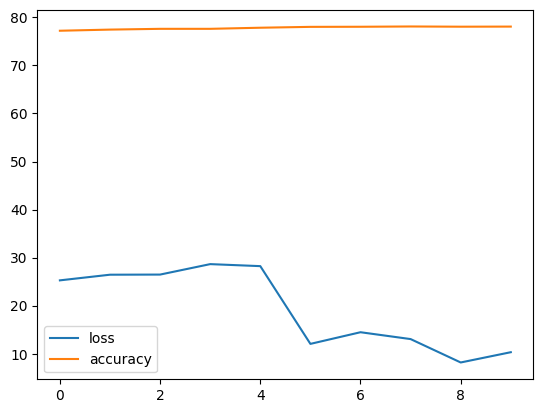

In [159]:
import matplotlib.pyplot as plt


plt.plot(loss_history, label="loss")
plt.plot(accuracy_history, label="accuracy") 
plt.legend()

In [160]:
val_losses = [99.5542,98.5022,95.2130,98.5903,98.8151,97.7996,98.3577,98.3070,98.8736,98.4011]

In [161]:
loss_history

[25.26823616027832,
 26.444141387939453,
 26.471364974975586,
 28.646488189697266,
 28.227388381958008,
 12.045987129211426,
 14.471874237060547,
 13.046003341674805,
 8.175924301147461,
 10.31430435180664]

In [162]:
val_loss_history    

[35.370058289409556,
 33.64187537144571,
 33.55078561462625,
 33.97794181238996,
 32.544666582650514,
 31.171646480142634,
 31.10807819436066,
 31.077361399239866,
 31.231418867180818,
 31.0976707012984]

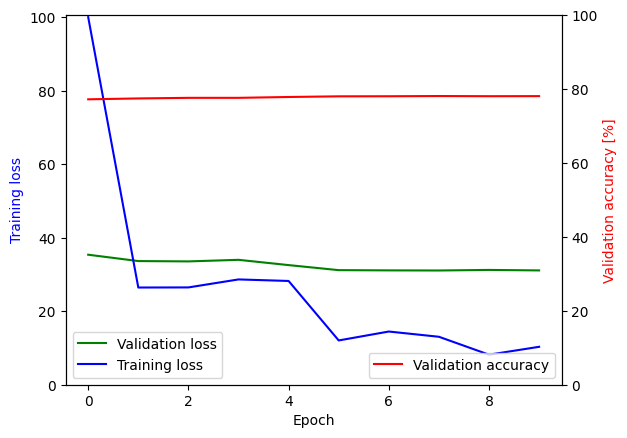

In [163]:
import matplotlib.pyplot as plt

epoch_cutoff = np.argmin(loss_history)
epoch_cutoff = 10

# Create a figure and primary y-axis
fig, ax1 = plt.subplots()
loss_history[0] = 100

# Plot data on the primary y-axis
ax1.plot(val_loss_history[:epoch_cutoff], color='green', label='Validation loss')
ax1.plot(loss_history[:epoch_cutoff], color='blue', label='Training loss')
ax1.set_ylabel('Training loss', color='blue')
ax1.set_ylim(0, max(val_losses) + 1)

# Create a secondary y-axis
ax2 = ax1.twinx()
ax2.set_ylim(0, 100)

# Plot data on the secondary y-axis
ax2.plot(accuracy_history[:epoch_cutoff], color='red', label='Validation accuracy')
ax2.set_ylabel('Validation accuracy [%]', color='red')

# Add legend
ax1.legend(loc='lower left')
ax2.legend(loc='lower right')
ax1.set_xlabel("Epoch")
ax1.set_xticks([2 * i for i in range(epoch_cutoff // 2)])
# Show plot
plt.show()